# CAPM Beta Estimation

This notebook demonstrates CAPM (Capital Asset Pricing Model) Beta estimation using Python.
We'll download stock data, calculate returns, estimate betas, and perform rolling-window analysis.

The CAPM model:
$$R_i - R_f = \alpha_i + \beta_i (R_m - R_f) + \epsilon_i$$

Where:
- $R_i$ = Return of asset i
- $R_f$ = Risk-free rate
- $R_m$ = Market return
- $\beta_i$ = Beta (systematic risk) of asset i
- $\alpha_i$ = Alpha (abnormal return) of asset i

## Import Required Libraries

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from IPython.display import display
from helpers import get_yahoo_data,create_resampled_datasets

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## Data Loading and Preprocessing

We'll download stock data for Microsoft (MSFT), Google (GOOGL), JPMorgan (JPM), General Electric (GE), 
along with the S&P 500 index (^GSPC) as our market proxy and 3-month Treasury Bill rate (^IRX) as the risk-free rate.

In [14]:
# Set up parameters
tickers = ['MSFT', 'GOOGL', 'JPM', 'GE', '^GSPC', '^IRX']
stock_names = ['MSFT', 'GOOGL', 'JPM', 'GE', 'SP500', 'TBill']

to_date = datetime.now()  # today

from_date = to_date - timedelta(days=5*365) 

start_date = from_date.strftime('%Y-%m-%d')
end_date = to_date.strftime('%Y-%m-%d')
interval = '1mo'  # daily frequency

In [15]:
prices = get_yahoo_data(
        ticker_list=tickers,
        start_date=start_date,
        end_date=end_date,
        interval=interval
    )

prices = prices.xs('Adj Close', axis=1, level=1)[tickers].dropna()
# Rename columns for clarity
prices.columns = stock_names
print("Data shape:", prices.shape)
print("\nFirst 5 rows:")
display(prices.head())

Data shape: (43, 6)

First 5 rows:


,MSFT,GOOGL,JPM,GE,SP500,TBill
Date,,,,,,
2020-11-01,205.255768,87.119125,104.034264,49.609848,3621.629883,0.075000
2020-12-01,213.820282,87.031738,112.144829,52.631279,3756.070068,0.065000
2021-01-01,222.991440,90.742134,113.556915,52.094364,3714.239990,0.048000
2021-02-01,223.395187,100.403008,130.819351,61.166973,3811.149902,0.035000
2021-03-01,227.176117,102.419609,135.317184,64.044861,3972.889893,0.013000


## Returns Calculation

Now we calculate logarithmic returns and prepare excess returns for CAPM analysis.
Using pandas operations instead of R's CalculateReturns function.

In [16]:
# Calculate log returns using pandas (vectorized operation, no loops needed)
def calculate_log_returns(prices_df):
    """
    Calculate logarithmic returns using pandas operations
    More efficient than R's CalculateReturns with a for loop
    """
    return np.log(prices_df / prices_df.shift(1)).dropna()

# Calculate returns for all assets except TBill (which is already a rate)
ret = calculate_log_returns(prices.iloc[:, :-1])  # Exclude TBill column
RF = prices['TBill'] / 100  # Convert TBill to decimal form

print("Returns shape:", ret.shape)
print("\nFirst 5 returns:")
display(ret.head())

print("\nReturns summary statistics:")
display(ret.describe())

Returns shape: (42, 5)

First 5 returns:


,MSFT,GOOGL,JPM,GE,SP500
Date,,,,,
2020-12-01,0.040879,-0.001004,0.075071,0.059121,0.036449
2021-01-01,0.041998,0.041749,0.012513,-0.010254,-0.011199
2021-02-01,0.001809,0.101170,0.141513,0.160551,0.025757
2021-03-01,0.016783,0.019886,0.033804,0.045976,0.041563
2021-04-01,0.067286,0.131975,0.010325,-0.000025,0.051097



Returns summary statistics:


,MSFT,GOOGL,JPM,GE,SP500
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.016506,0.016101,0.015213,0.028411,0.008965
std,0.064450,0.077935,0.074020,0.095220,0.048690
min,-0.113590,-0.197801,-0.160612,-0.206706,-0.098049
25%,-0.023586,-0.036367,-0.040501,-0.015164,-0.025401
50%,0.018915,0.023135,0.023620,0.023812,0.022232
75%,0.062234,0.070128,0.070632,0.076370,0.043131
max,0.162366,0.141315,0.186142,0.229828,0.087201


In [17]:
# Calculate excess returns (asset returns minus risk-free rate)
# Using pandas operations instead of R's rep() function
def calculate_excess_returns(returns_df, risk_free_rate):
    """
    Calculate excess returns using pandas broadcasting
    More elegant than R's rep() function approach
    """
    # Align the risk-free rate with returns dates
    rf_aligned = risk_free_rate.reindex(returns_df.index, method='ffill') / 100
    
    # Calculate excess returns for stocks (excluding market index)
    stock_excess = returns_df.iloc[:, :-1].sub(rf_aligned, axis=0)
    
    # Calculate market excess returns
    market_excess = returns_df.iloc[:, -1] - rf_aligned
    
    return stock_excess, market_excess, rf_aligned

# Calculate excess returns
ret_excess, mkt_excess, rf_aligned = calculate_excess_returns(ret, RF)

print("Stock excess returns shape:", ret_excess.shape)
print("Market excess returns shape:", mkt_excess.shape)

print("\nStock excess returns (first 5 rows):")
display(ret_excess.head())

print("\nMarket excess returns (first 5 values):")
print(mkt_excess.head())

Stock excess returns shape: (42, 4)
Market excess returns shape: (42,)

Stock excess returns (first 5 rows):


,MSFT,GOOGL,JPM,GE
Date,,,,
2020-12-01,0.040873,-0.001010,0.075064,0.059115
2021-01-01,0.041993,0.041744,0.012508,-0.010259
2021-02-01,0.001805,0.101167,0.141510,0.160547
2021-03-01,0.016782,0.019885,0.033803,0.045975
2021-04-01,0.067286,0.131975,0.010325,-0.000025



Market excess returns (first 5 values):
Date
2020-12-01    0.036443
2021-01-01   -0.011204
2021-02-01    0.025753
2021-03-01    0.041562
2021-04-01    0.051097
Freq: MS, dtype: float64


## Basic CAPM Analysis

Now we perform the fundamental CAPM regression analysis using statsmodels.
We'll calculate beta, alpha, and various CAPM metrics for each stock.

In [23]:
# CAPM Regression Analysis using statsmodels (more sophisticated than R's lm)
def capm_regression(stock_excess, market_excess):
    """
    Perform CAPM regression using statsmodels
    Returns alpha, beta, and regression statistics
    
    Robust to cases where the regression drops the market column (e.g. all-NaN/collinear),
    avoiding KeyError when params[1] does not exist.
    """
    # Add constant for intercept (alpha)
    X = sm.add_constant(market_excess)
    
    try:
        # Fit the model
        model = sm.OLS(stock_excess, X, missing='drop').fit()
    except Exception:
        # In case fitting fails, return NaNs and None model
        return {
            'alpha': np.nan,
            'beta': np.nan,
            'alpha_pvalue': np.nan,
            'beta_pvalue': np.nan,
            'r_squared': np.nan,
            'model': None
        }
    
    params = model.params
    pvalues = model.pvalues
    
    # Safely extract alpha (intercept) and beta (market slope)
    # params may be a Series indexed by ['const', <market_name>] or positional
    try:
        if len(params) >= 1:
            # intercept / alpha
            alpha = params.iloc[0]
            alpha_p = pvalues.iloc[0] if len(pvalues) >= 1 else np.nan
        else:
            alpha = np.nan
            alpha_p = np.nan

        if len(params) >= 2:
            beta = params.iloc[1]
            beta_p = pvalues.iloc[1] if len(pvalues) >= 2 else np.nan
        else:
            # Market regressor was dropped / not present
            beta = np.nan
            beta_p = np.nan
    except Exception:
        alpha = np.nan
        beta = np.nan
        alpha_p = np.nan
        beta_p = np.nan

    # r_squared may not be meaningful if model is None
    r_squared = model.rsquared if model is not None else np.nan

    return {
        'alpha': alpha,
        'beta': beta,
        'alpha_pvalue': alpha_p,
        'beta_pvalue': beta_p,
        'r_squared': r_squared,
        'model': model
    }

# Perform CAPM regression for all stocks using pandas operations
capm_results = {}
for stock in ret_excess.columns:
    capm_results[stock] = capm_regression(ret_excess[stock], mkt_excess)

# Create summary dataframe
capm_summary = pd.DataFrame({
    stock: {
        'Alpha': results['alpha']*12*100,
        'Beta': results['beta'],
        'Alpha p-value': results['alpha_pvalue'],
        'Beta p-value': results['beta_pvalue'],
        'R-squared': results['r_squared']
    } for stock, results in capm_results.items()
}).T

print("CAPM Regression Results:")
display(capm_summary)

CAPM Regression Results:


,Alpha,Beta,Alpha p-value,Beta p-value,R-squared
MSFT,8.770811,1.026675,0.264427,0.000000,0.601447
GOOGL,7.433070,1.108301,0.491748,0.000000,0.479239
JPM,7.180846,1.030302,0.492345,0.000001,0.459397
GE,19.566461,1.361123,0.140420,0.000000,0.484826


In [24]:
# Additional CAPM metrics (bull/bear betas, timing ratio)
def calculate_bull_bear_metrics(stock_excess, market_excess):
    """
    Calculate bull and bear betas, and timing ratio
    Replaces R's PerformanceAnalytics functions with pandas operations
    """
    # Combine data for easier manipulation
    data = pd.DataFrame({
        'stock': stock_excess,
        'market': market_excess
    }).dropna()
    
    # Bull market (positive market returns)
    bull_data = data[data['market'] > 0]
    bear_data = data[data['market'] <= 0]
    
    results = {}
    
    if len(bull_data) > 10:  # Minimum observations
        X_bull = sm.add_constant(bull_data['market'])
        model_bull = sm.OLS(bull_data['stock'], X_bull).fit()
        results['beta_bull'] = model_bull.params[1]
    else:
        results['beta_bull'] = np.nan
    
    if len(bear_data) > 10:  # Minimum observations
        X_bear = sm.add_constant(bear_data['market'])
        model_bear = sm.OLS(bear_data['stock'], X_bear).fit()
        results['beta_bear'] = model_bear.params[1]
    else:
        results['beta_bear'] = np.nan
    
    # Timing ratio
    if not np.isnan(results['beta_bull']) and not np.isnan(results['beta_bear']) and results['beta_bear'] != 0:
        results['timing_ratio'] = results['beta_bull'] / results['beta_bear']
    else:
        results['timing_ratio'] = np.nan
    
    return results

# Calculate bull/bear metrics for all stocks
bull_bear_metrics = {}
for stock in ret_excess.columns:
    bull_bear_metrics[stock] = calculate_bull_bear_metrics(ret_excess[stock], mkt_excess)

# Create summary dataframe
bull_bear_df = pd.DataFrame(bull_bear_metrics).T
print("Bull/Bear Beta Analysis:")
display(bull_bear_df)

Bull/Bear Beta Analysis:


,beta_bull,beta_bear,timing_ratio
MSFT,0.547827,1.253309,0.437105
GOOGL,-0.184602,1.462400,-0.126232
JPM,0.931297,1.460910,0.637477
GE,1.570478,2.095657,0.749397


## Rolling Window Beta Estimation

This section implements rolling window analysis using pandas operations instead of the R for loop.
We'll use a 60-month rolling window to estimate time-varying betas and alphas.

In [26]:
# Rolling window CAPM estimation using pandas (vectorized and avoids returning Series from rolling.apply)
def rolling_capm(stock_excess, market_excess, window=60):
    """
    Calculate rolling beta and alpha using pandas rolling operations.
    Uses rolling covariance / variance to compute beta and then alpha = mean(stock) - beta * mean(market).
    This avoids using rolling.apply with a function that returns multiple values (which causes the
    "cannot convert the series to <class 'float'>" TypeError).
    """
    # Ensure inputs are aligned
    stock = stock_excess.reindex(market_excess.index)
    market = market_excess.reindex(stock_excess.index)
    
    # Minimum observations per window (keep a sensible floor)
    min_periods = max(10, window // 2)
    
    # Rolling covariance and variance (sample statistics, ddof=1 by default)
    cov_sm = stock.rolling(window=window, min_periods=min_periods).cov(market)
    var_m = market.rolling(window=window, min_periods=min_periods).var()
    
    # Beta = cov(stock, market) / var(market)
    beta = cov_sm / var_m
    
    # Rolling means
    stock_mean = stock.rolling(window=window, min_periods=min_periods).mean()
    market_mean = market.rolling(window=window, min_periods=min_periods).mean()
    
    # Alpha = mean(stock) - beta * mean(market)
    alpha = stock_mean - beta * market_mean
    
    # Combine into a DataFrame with consistent index
    rolling_df = pd.DataFrame({'alpha': alpha, 'beta': beta})
    return rolling_df

# Calculate rolling betas and alphas for all stocks
window_size = 60
print(f"Calculating {window_size}-month rolling betas and alphas...")

rolling_results = {}
for stock in ret_excess.columns:
    print(f"Processing {stock}...")
    rolling_results[stock] = rolling_capm(ret_excess[stock], mkt_excess, window_size)

print("Rolling window calculation completed!")

Calculating 60-month rolling betas and alphas...
Processing MSFT...
Processing GOOGL...
Processing JPM...
Processing GE...
Rolling window calculation completed!


In [27]:
# Organize rolling results into separate dataframes for betas and alphas
# More organized than R's separate matrices approach
rolling_betas = pd.DataFrame({
    stock: results['beta'] for stock, results in rolling_results.items()
})

rolling_alphas = pd.DataFrame({
    stock: results['alpha'] for stock, results in rolling_results.items()
})

print("Rolling Beta Results (first 5 rows):")
display(rolling_betas.head())

print(f"\nRolling Betas shape: {rolling_betas.shape}")
print(f"Rolling Alphas shape: {rolling_alphas.shape}")

# Basic statistics
print("\nRolling Beta Summary Statistics:")
display(rolling_betas.describe())

Rolling Beta Results (first 5 rows):


,MSFT,GOOGL,JPM,GE
Date,,,,
2020-12-01,NaN,NaN,NaN,NaN
2021-01-01,NaN,NaN,NaN,NaN
2021-02-01,NaN,NaN,NaN,NaN
2021-03-01,NaN,NaN,NaN,NaN
2021-04-01,NaN,NaN,NaN,NaN



Rolling Betas shape: (42, 4)
Rolling Alphas shape: (42, 4)

Rolling Beta Summary Statistics:


,MSFT,GOOGL,JPM,GE
count,13.000000,13.000000,13.000000,13.000000
mean,1.034462,1.204271,0.987721,1.457174
std,0.027201,0.057738,0.033758,0.044644
min,1.000113,1.108301,0.938903,1.361123
25%,1.014095,1.173608,0.959273,1.436002
50%,1.026675,1.198969,0.993208,1.464705
75%,1.050287,1.238141,1.015837,1.488463
max,1.094859,1.315939,1.030302,1.514516


## Visualizations

Converting R's ggplot2 visualizations to Python's matplotlib and seaborn.
We'll create time series plots of rolling betas/alphas and distribution plots.

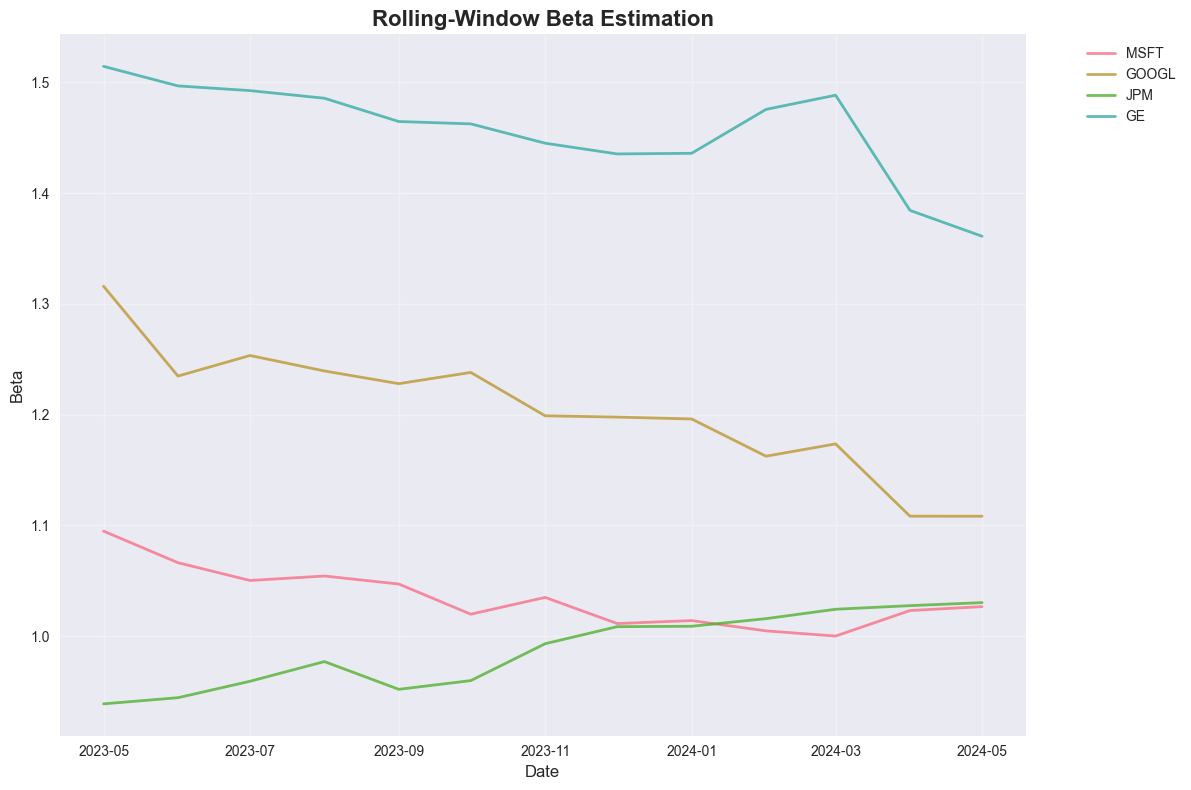

In [28]:
plt.figure(figsize=(12, 8))

for i, stock in enumerate(rolling_betas.columns):
    plt.plot(rolling_betas.index, rolling_betas[stock], 
             label=stock, linewidth=2, alpha=0.8)

plt.title('Rolling-Window Beta Estimation', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

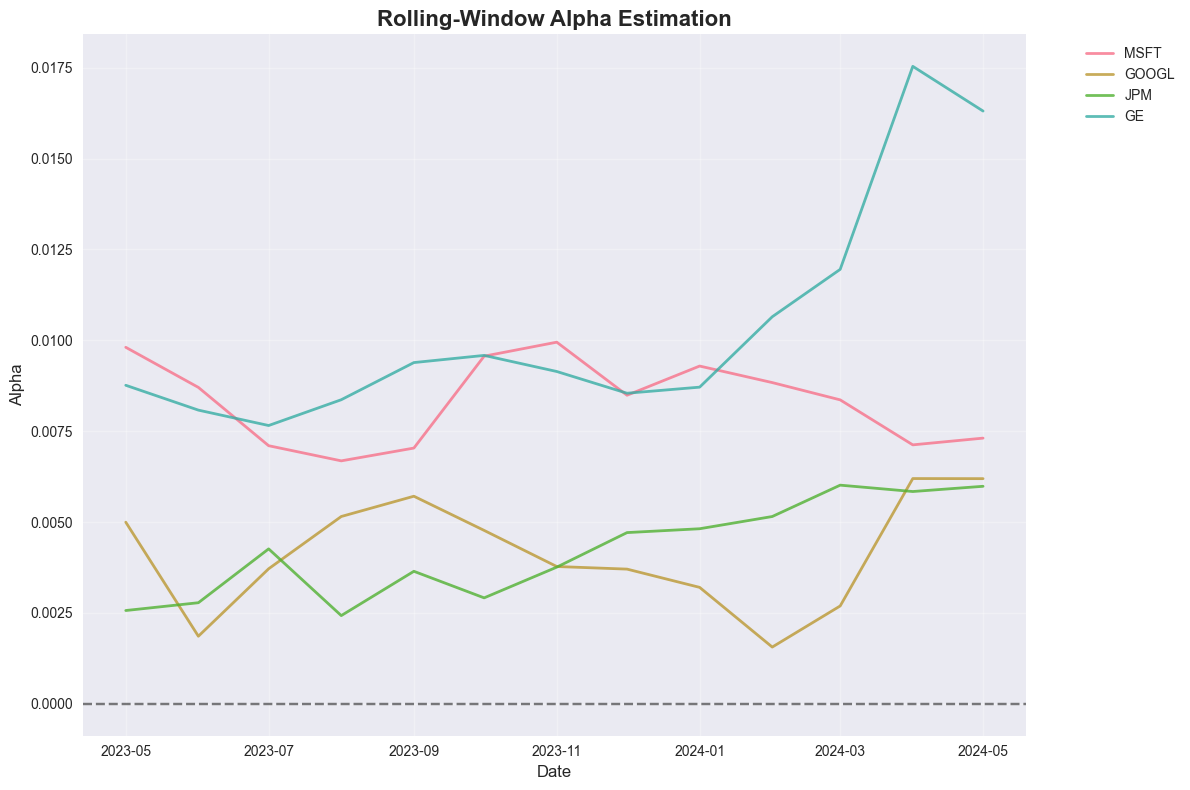

In [29]:
# Rolling Alpha Time Series Plot
plt.figure(figsize=(12, 8))

for i, stock in enumerate(rolling_alphas.columns):
    plt.plot(rolling_alphas.index, rolling_alphas[stock], 
             label=stock, linewidth=2, alpha=0.8)

plt.title('Rolling-Window Alpha Estimation', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Alpha', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)  # Reference line at 0
plt.tight_layout()
plt.show()

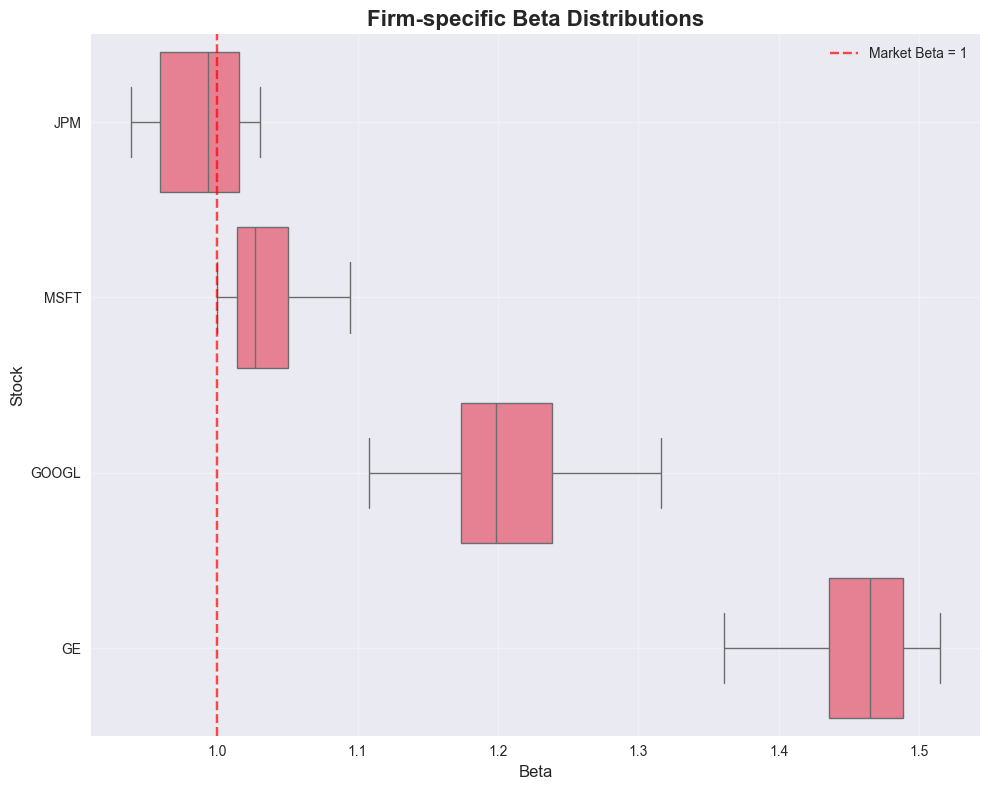

In [30]:
# Beta Distribution Box Plots (replacing R's ggplot2 boxplot)
# Prepare data in long format for seaborn (similar to R's gather function)
beta_long = rolling_betas.melt(var_name='Stock', value_name='Beta', ignore_index=False)
beta_long = beta_long.dropna()

# Create the boxplot using seaborn (more elegant than matplotlib)
plt.figure(figsize=(10, 8))
sns.boxplot(data=beta_long, y='Stock', x='Beta', 
           order=beta_long.groupby('Stock')['Beta'].median().sort_values().index)

plt.title('Firm-specific Beta Distributions', fontsize=16, fontweight='bold')
plt.xlabel('Beta', fontsize=12)
plt.ylabel('Stock', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='Market Beta = 1')
plt.legend()
plt.tight_layout()
plt.show()

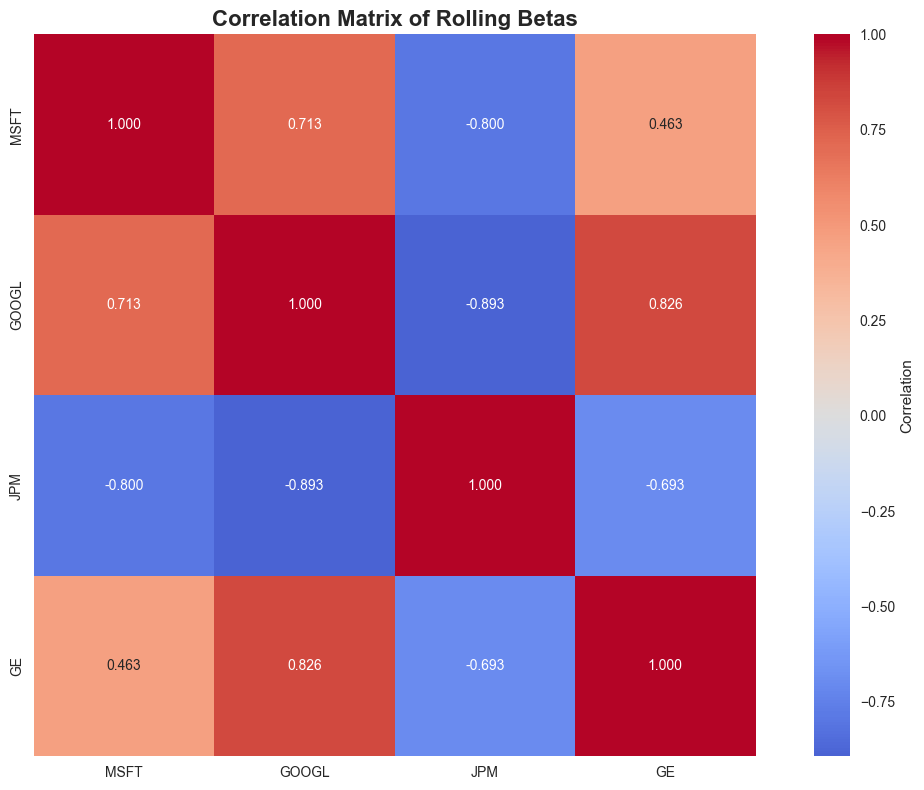

Beta Correlation Summary:
This heatmap shows how the systematic risk (beta) of different stocks
correlate with each other over time. High correlations suggest
stocks move similarly relative to the market.


In [31]:
# Additional: Interactive plot using seaborn's pairplot for correlation analysis
# This goes beyond the original R code by providing more insights
plt.figure(figsize=(12, 8))

# Correlation matrix of rolling betas
correlation_matrix = rolling_betas.corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})

plt.title('Correlation Matrix of Rolling Betas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Beta Correlation Summary:")
print("This heatmap shows how the systematic risk (beta) of different stocks")
print("correlate with each other over time. High correlations suggest")
print("stocks move similarly relative to the market.")